<a href="https://colab.research.google.com/github/OdysseusPolymetis/enssib_class/blob/main/4_bertalign_course.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Alignement automatique de textes**
---

**Bertalign** est un outil d'alignement bilingue (ou plutôt *bi-texte*) qui cherche à mettre en correspondance des **segments** (souvent des phrases) entre un texte source et un texte cible.

La version actuelle de Bertalign n'est pas bien entretenue, alors on va utiliser ma version mise à jour (je pense que si vous prenez la version par défaut dans colab, vous allez avoir du mal).

## L'idée générale
1. **Segmenter** les deux textes (souvent en phrases).
2. Transformer chaque segment en **vecteur sémantique** (embeddings) via un modèle multilingue (souvent **LaBSE**).
3. Calculer des similarités et trouver un **chemin d'alignement** qui respecte l'ordre du texte (alignement monotone).
4. Produire des liens d'alignement **pas forcément 1↔1** : Bertalign gère bien les cas littéraires où une phrase peut être traduite / reformulée par plusieurs phrases, ou inversement.

> En sortie, Bertalign retourne typiquement une liste de paires d'indices : `([ids_src], [ids_tgt])`, ce qui permet de représenter du **1↔N**, **N↔1**, voire **N↔M**.

## Phénomènes illustrés ci-dessous
- **1↔1** : correspondance simple
- **1↔N** : une phrase du pivot correspond à plusieurs phrases dans une autre version
- **N↔1** : plusieurs phrases du pivot fusionnent en une seule chez un autre auteur
- **N↔M** : regroupements des deux côtés
- **Orphelines** : segments difficiles à rattacher (selon la stratégie, ils sont ignorés, attachés au voisin, etc.)

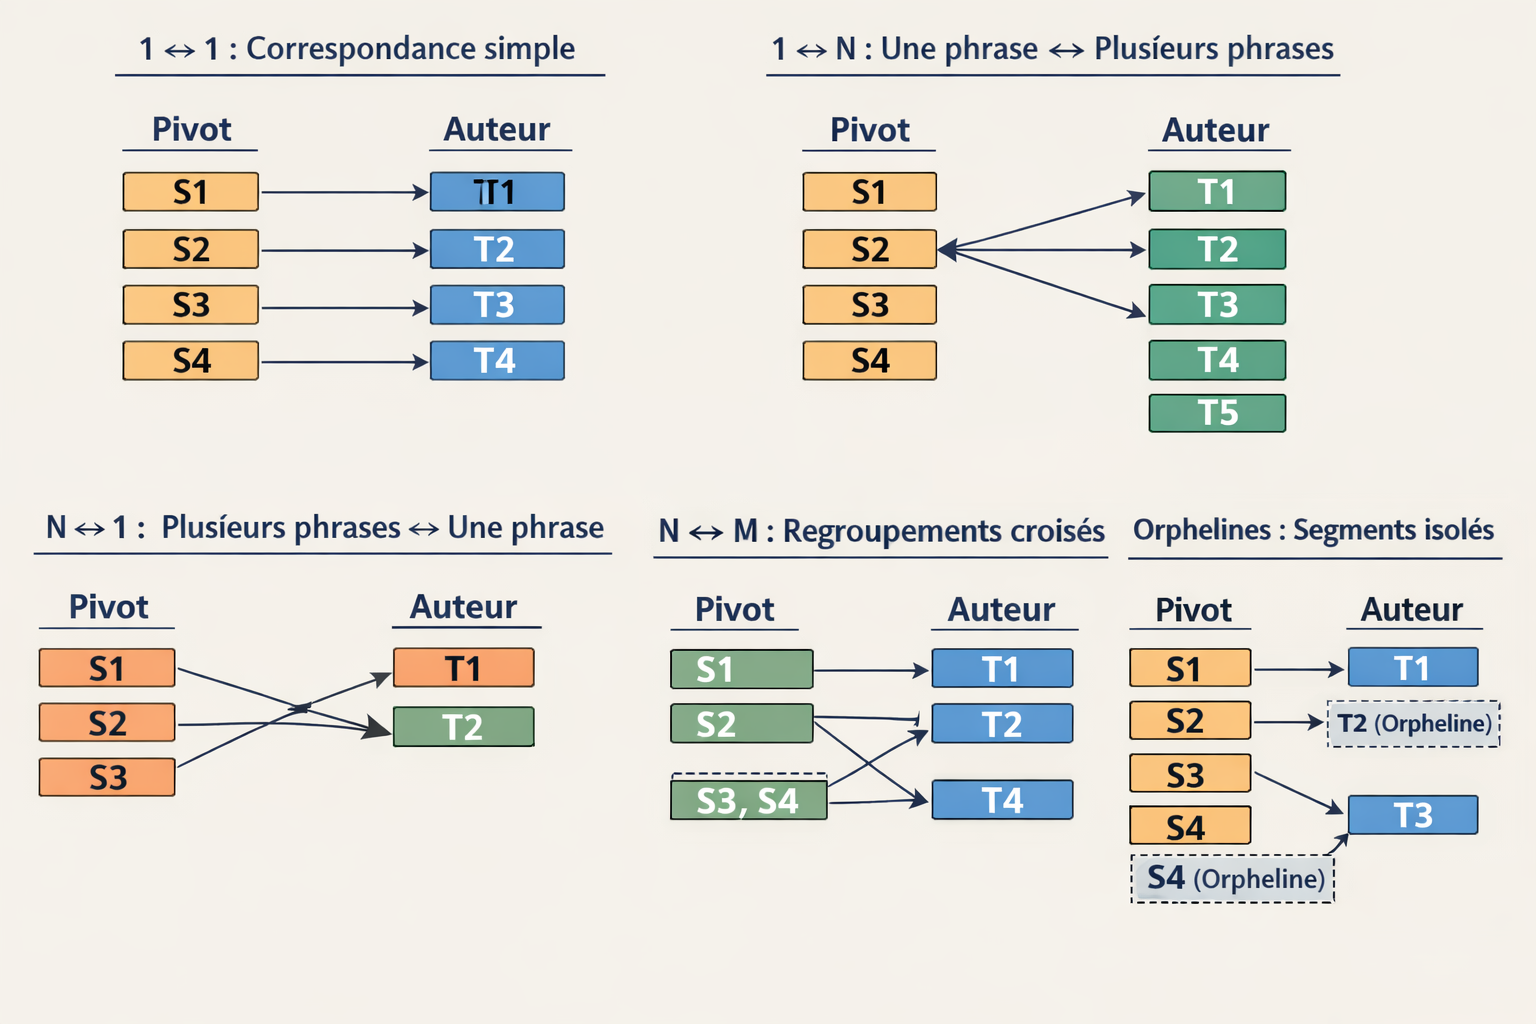

In [34]:
import os

os.environ["HF_HOME"] = "/content/hf"

os.environ["HF_HUB_ETAG_TIMEOUT"] = "120"
os.environ["HF_HUB_DOWNLOAD_TIMEOUT"] = "600"

In [ ]:
!git clone --depth 1 https://github.com/OdysseusPolymetis/pyOdysseus.git
!git clone --depth 1 https://github.com/OdysseusPolymetis/homersOdysseys.git

!ls -lah
!ls -lah homersOdysseys
!ls -lah homersOdysseys/txt | head -n 50

In [29]:
from sentence_transformers import SentenceTransformer
_ = SentenceTransformer("sentence-transformers/LaBSE")

In [30]:
os.environ["HF_HUB_OFFLINE"] = "1"
os.environ["TRANSFORMERS_OFFLINE"] = "1"

In [ ]:
!pip install -r /content/pyOdysseus/bertalign_odysseus/requirements.txt

In [ ]:
import sys, os
sys.path.insert(0, "/content/pyOdysseus/bertalign_odysseus")

try:
    from bertalign import Bertalign
    print("OK: import Bertalign depuis /pyOdysseus/bertalign_odysseus")
except Exception as e:
    print("Import direct échoué:", e)
    print("\nContenu du dossier bertalign_odysseus :")
    !find /content/pyOdysseus/bertalign_odysseus -maxdepth 3 -type f | head -n 200

In [4]:
import glob, os, re
from pathlib import Path
import pandas as pd
from tqdm import tqdm
from sentence_splitter import SentenceSplitter
from IPython.display import HTML, display

In [5]:
TXT_DIR = "/content/homersOdysseys/txt"
OUT_DIR = "/content/odysseus_html"
os.makedirs(OUT_DIR, exist_ok=True)

In [6]:
CHANT_RE = re.compile(r"(?im)^\s*chant\s*(\d+)\b.*$", re.MULTILINE)

In [7]:
def read_text(path: str) -> str:
    return Path(path).read_text(encoding="utf-8", errors="ignore")

In [8]:
def split_by_chant(text: str):
    """Retourne dict: chant_num (int) -> contenu du chant (str)."""
    matches = list(CHANT_RE.finditer(text))
    if not matches:
        return {0: text.strip()}
    out = {}
    for i, m in enumerate(matches):
        chant_num = int(m.group(1))
        start = m.end()
        end = matches[i+1].start() if i+1 < len(matches) else len(text)
        out[chant_num] = text[start:end].strip()
    return out

In [9]:
splitter = SentenceSplitter(language="fr")

In [10]:
def sent_split(s: str):
    s = re.sub(r"\s+", " ", s).strip()
    if not s:
        return []
    return [x.strip() for x in splitter.split(s) if x.strip()]

In [20]:
def safe_align(src_sents, tgt_sents):
    src_text = "\n".join(src_sents)
    tgt_text = "\n".join(tgt_sents)

    aligner = Bertalign(src_text, tgt_text)
    aligner.align_sents()

    src_used = getattr(aligner, "src_sents", src_sents)
    tgt_used = getattr(aligner, "tgt_sents", tgt_sents)

    return aligner, src_used, tgt_used

In [12]:
paths = sorted(glob.glob(f"{TXT_DIR}/*.txt"))
if not paths:
    raise RuntimeError("Aucun .txt trouvé dans homersOdysseys/txt")

In [13]:
def author_name(p):
    return Path(p).stem

In [14]:
authors = {author_name(p): p for p in paths}
print("Auteurs trouvés:", list(authors.keys()))

Auteurs trouvés: ['Bareste1842', 'Berard1924', 'Bignan1853', 'Bitaube1810', 'Boitel1619', 'CalbetRosny1897', 'Certon1604', 'Dacier1872', 'DufourRaison1946', 'DugasMontbel1833', 'Froment1883', 'Giguet1852', 'Gin1783', 'Hins1883', 'Jamyn1584', 'LCDLisle1867', 'LPLBrun1819', 'LaValterie1681', 'Meunier1943', 'PeletierDuMans1540', 'Pessonneaux1866', 'Rochefort1777', 'Seguier1896', 'Sommer1886']


In [15]:
pivot_author = next((a for a in authors if "sommer" in a.lower()), list(authors.keys())[0])
print("Pivot:", pivot_author)

Pivot: Sommer1886


In [16]:
chants_by_author = {}
all_chants = set()

for a, p in authors.items():
    chants = split_by_chant(read_text(p))
    chants_by_author[a] = chants
    all_chants |= set(chants.keys())

all_chants = sorted(c for c in all_chants if c != 0) or [0]
print("Chants détectés:", all_chants[:10], "... total:", len(all_chants))

Chants détectés: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10] ... total: 24


In [21]:
from __future__ import annotations

from typing import Dict, List, Optional, Tuple, Union
import pandas as pd

IdLike = Union[int, List[int], Tuple[int, ...]]

In [22]:
def align_to_pivot_table(
    chant_num: int,
    *,
    pivot_author: str,
    authors: List[str],
    chants_by_author: Dict[str, Dict[int, str]],
    sent_split,
    safe_align,
) -> Optional[pd.DataFrame]:

    def _norm_ids(ids: IdLike, n: int) -> List[int]:

        if ids is None:
            return []
        if isinstance(ids, int):
            ids = [ids]
        else:
            ids = list(ids)

        if not ids:
            return []


        if min(ids) >= 1 and max(ids) == n:
            ids = [i - 1 for i in ids]


        return [i for i in ids if 0 <= i < n]


    pivot_text = chants_by_author.get(pivot_author, {}).get(chant_num, "") or ""
    pivot_sents = sent_split(pivot_text)
    if not pivot_sents:
        return None


    df = pd.DataFrame({pivot_author: pivot_sents})
    df.index = [f"{chant_num}:{i+1}" for i in range(len(pivot_sents))]


    for author in authors:
        if author == pivot_author:
            continue

        tgt_text = chants_by_author.get(author, {}).get(chant_num, "") or ""
        tgt_sents = sent_split(tgt_text)


        if not tgt_sents:
            df[author] = ""
            continue


        aligner, pivot_used, tgt_used = safe_align(df[pivot_author].tolist(), tgt_sents)


        result = getattr(aligner, "result", None)
        if not result:
            df[author] = ""
            continue


        if len(pivot_used) != len(df):
            df = pd.DataFrame({pivot_author: list(pivot_used)})
            df.index = [f"{chant_num}:{i+1}" for i in range(len(pivot_used))]

        mapped: List[str] = [""] * len(df)


        for src_ids, tgt_ids in result:
            src_ids_n = _norm_ids(src_ids, len(df))
            tgt_ids_n = _norm_ids(tgt_ids, len(tgt_used))

            if not src_ids_n:
                continue

            tgt_txt = " ".join(tgt_used[i] for i in tgt_ids_n).strip()

            for si in src_ids_n:
                if mapped[si]:
                    mapped[si] = (mapped[si] + " " + tgt_txt).strip()
                else:
                    mapped[si] = tgt_txt

        df[author] = mapped

    return df

In [18]:
CSS = """
<style>
table { border-collapse: collapse; width: 100%; }
th, td { border: 1px solid #ddd; padding: 8px; vertical-align: top; }
th { position: sticky; top: 0; background: #f6f6f6; z-index: 1; }
td { font-size: 14px; line-height: 1.35; }
caption { font-weight: 600; margin: 10px 0; }
</style>
"""

In [31]:
def write_chants_html_resume(
    all_chants,
    *,
    pivot_author,
    authors,
    chants_by_author,
    sent_split,
    safe_align,
    out_dir,
    css,
):
    out_path = Path(out_dir)
    out_path.mkdir(parents=True, exist_ok=True)

    index_links = []

    for chant in tqdm(all_chants, desc="Chants -> HTML"):
        filename = "fulltext.html" if chant == 0 else f"chant_{chant:02d}.html"
        file_path = out_path / filename


        if file_path.exists():
            index_links.append((chant, filename))
            continue

        df = align_to_pivot_table(
            chant,
            pivot_author=pivot_author,
            authors=authors,
            chants_by_author=chants_by_author,
            sent_split=sent_split,
            safe_align=safe_align,
        )
        if df is None:
            continue

        if "pivot" in df.columns:
            df = df.rename(columns={"pivot": pivot_author})

        file_path.write_text(css + df.to_html(escape=False), encoding="utf-8")
        index_links.append((chant, filename))

    return index_links

In [35]:
html_index_links = write_chants_html_resume(
    all_chants,
    pivot_author=pivot_author,
    authors=list(authors.keys()) if isinstance(authors, dict) else list(authors),
    chants_by_author=chants_by_author,
    sent_split=sent_split,
    safe_align=safe_align,
    out_dir=OUT_DIR,
    css=CSS,
)


Chants -> HTML:   0%|          | 0/24 [00:00<?, ?it/s]

Source language: French, Number of sentences: 275
Target language: French, Number of sentences: 337
Embedding source and target text using LaBSE ...
Performing first-step alignment ...
Performing second-step alignment ...
Finished! Successfully aligning 275 French sentences to 337 French sentences

Source language: French, Number of sentences: 275
Target language: French, Number of sentences: 289
Embedding source and target text using LaBSE ...
Performing first-step alignment ...
Performing second-step alignment ...
Finished! Successfully aligning 275 French sentences to 289 French sentences

Source language: French, Number of sentences: 275
Target language: French, Number of sentences: 337
Embedding source and target text using LaBSE ...
Performing first-step alignment ...
Performing second-step alignment ...
Finished! Successfully aligning 275 French sentences to 337 French sentences

Source language: French, Number of sentences: 275
Target language: French, Number of sentences: 358


Chants -> HTML:  17%|█▋        | 4/24 [05:11<25:57, 77.86s/it]

Source language: French, Number of sentences: 160
Target language: French, Number of sentences: 192
Embedding source and target text using LaBSE ...
Performing first-step alignment ...
Performing second-step alignment ...
Finished! Successfully aligning 160 French sentences to 192 French sentences

Source language: French, Number of sentences: 160
Target language: French, Number of sentences: 163
Embedding source and target text using LaBSE ...
Performing first-step alignment ...
Performing second-step alignment ...
Finished! Successfully aligning 160 French sentences to 163 French sentences

Source language: French, Number of sentences: 160
Target language: French, Number of sentences: 183
Embedding source and target text using LaBSE ...
Performing first-step alignment ...
Performing second-step alignment ...
Finished! Successfully aligning 160 French sentences to 183 French sentences

Source language: French, Number of sentences: 160
Target language: French, Number of sentences: 203


Chants -> HTML:  21%|██        | 5/24 [08:53<36:41, 115.86s/it]

Source language: French, Number of sentences: 106
Target language: French, Number of sentences: 121
Embedding source and target text using LaBSE ...
Performing first-step alignment ...
Performing second-step alignment ...
Finished! Successfully aligning 106 French sentences to 121 French sentences

Source language: French, Number of sentences: 106
Target language: French, Number of sentences: 122
Embedding source and target text using LaBSE ...
Performing first-step alignment ...
Performing second-step alignment ...
Finished! Successfully aligning 106 French sentences to 122 French sentences



Chants -> HTML:  21%|██        | 5/24 [09:20<35:30, 112.11s/it]


ReadTimeout: The read operation timed out